![logo](../LogoLine_horizon_C3S.png)

# Deriving ENSO indices used in C3S graphical products from CDS data

In this example we how to compute the El Niño–Southern Oscillation (ENSO) indices used in [C3S seasonal graphical products](https://climate.copernicus.eu/charts/packages/c3s_seasonal/), from ERA5 SST data retrieved from the CDS. This is also shown for one seasonal forecast system, computing some ENSO indices over the hindcast period.

In a complementary Notebook, the indices prepared here we be used to compute the correlation heatmaps displayed for the SST indices on the [verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots). 

Some information on ENSO impacts in Europe can be found on [a page in the C3S documentation](https://confluence.ecmwf.int/display/COPSRV/ENSO+impacts+on+Europe).

1. [Configuration](#configuration)
2. [CDS API requests](#cds-api-requests)
3. [Define ENSO regions](#define-enso-regions)
4. [Compute indices](#compute-indices)


## Configuration

Import required modules and configure CDS API key and client.

In [ ]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import regionmask
import cdsapi
import os

# Need to leave this blank and the user needs to enter their url and key here
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '' # INSERT CDS KEY HERE
c = cdsapi.Client(url=URL, key=KEY)

## Define ENSO regions

Define some characteristics of the SST indices to calculate for this example. Then create a `regionmask` object based on them. For further details see the [regionmask package documentation](https://regionmask.readthedocs.io/en/stable/).

In [5]:
nino_bboxes = list()
nino_bboxes.append(np.array([[270, -10], [270, 0], [280, 0], [280, -10]]))  # NINO12
nino_bboxes.append(np.array([[210, -5], [210, 5], [270, 5], [270, -5]]))  # NINO3
nino_bboxes.append(np.array([[190, -5], [190, 5], [240, 5], [240, -5]]))  # NINO34
nino_bboxes.append(np.array([[160, -5], [160, 5], [210, 5], [210, -5]]))  # NINO4

names = ["NINO1+2", "NINO3", "NINO3.4", "NINO4"]
abbrevs = [n.split("NINO")[1] for n in names]

ind_defs = regionmask.Regions(nino_bboxes, names=names, abbrevs=abbrevs, name="NINO")

Plot the defined regions to check everything is working as expected.

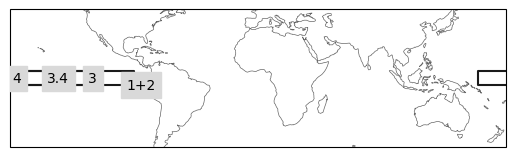

In [6]:
ax = ind_defs.plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

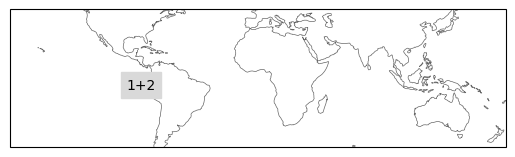

In [7]:
# plot one by one due to overlaps
ax = ind_defs[["NINO1+2"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

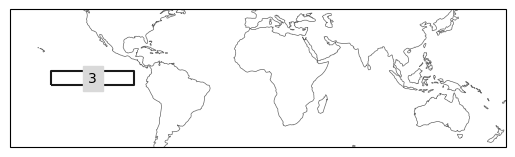

In [8]:
ax = ind_defs[["NINO3"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

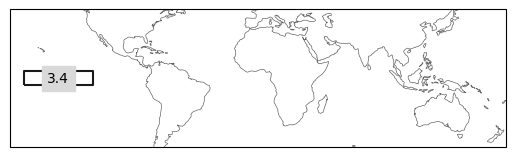

In [9]:
ax = ind_defs[["NINO3.4"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

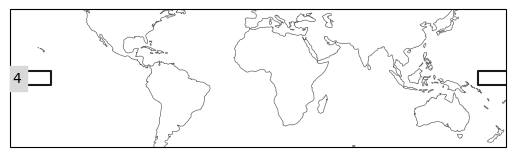

In [10]:
# note that the package deals with the wrapping of the coordinates
ax = ind_defs[["NINO4"]].plot(label='abbrev')
ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())

Note that the region mask package assigns a number to each region, which is the integer used in the mask.

## ERA5 CDS API request

 Define a directory where the data will be saved. Set request details to be used by the API requests, and perform the API request.

The CDS API keywords used are:


**Product type**: `monthly_averaged_reanalysis`<br>
**Variable**: `sea_surface_temperature` <br>
**Year**: `1993 to 2016` *the common hindcast period* <br>
**Month**: `01 to 12` *all months* <br>
**Time**: `00:00` *the only option for monthly means* <br>
**Format**: `grib` <br>
**Download format**: `unarchived` *returned file is not zipped*<br>

In [ ]:
data_path = '/data' # REPLACE BEFORE PUBLICATION

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": ["sea_surface_temperature"],
    "year": [
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "unarchived"
}

print(data_path + '/era5_monthly_sst_hc_period.grib')
client.retrieve(dataset, request, data_path + '/era5_monthly_sst_hc_period.grib')

## Compute ERA5 indices and save

Load the data into xarray. Then define a mask using the `mask_3D_frac_approx` function, which deals with fractional overlap between the defined regions and grid cells (indicating how much of the grid cell is covered by the region), which can help to create more exact regional means.

Then, apply the mask and compute the cell-weighted area average.

In [ ]:
# read in data
sst_data = xr.open_dataarray(data_path + '/era5_monthly_sst_hc_period.grib', engine='cfgrib')
sst_data = sst_data.rename({'longitude': 'lon','latitude': 'lat'})

# apply the mask and compute area average
sst_data_mask = ind_defs.mask_3D_frac_approx(sst_data)
weights = np.cos(np.deg2rad(sst_data.lat))
sst_inds = sst_data.weighted(sst_data_mask * weights).mean(dim=("lat", "lon"))

Inspect the data objects that were just used and produced.

In [15]:
sst_data

<xarray.DataArray 'sst' (time: 288, lat: 721, lon: 1440)> Size: 1GB
array([[[271.45972, 271.45972, ..., 271.45972, 271.45972],
        [271.45972, 271.45972, ..., 271.45972, 271.45972],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[271.45972, 271.45972, ..., 271.45972, 271.45972],
        [271.45972, 271.45972, ..., 271.45972, 271.45972],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[271.46045, 271.46045, ..., 271.46045, 271.46045],
        [271.46045, 271.46045, ..., 271.46045, 271.46045],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[271.46045, 271.46045, ..., 271.46045, 271.46045],
        [271.46045, 271.46045, ..., 271.46045, 271.46045],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    valid_time  (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
Attributes: (12/30)
    GRIB_paramId:                             34
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_name:                                Sea surface temperature
    GRIB_shortName:                           sst
    GRIB_units:                               K
    long_name:                                Sea surface temperature
    units:                                    K
    standard_name:                            unknown

In [16]:
sst_inds

<xarray.DataArray 'sst' (time: 288, region: 4)> Size: 9kB
array([[297.40361302, 298.71589459, 299.96271057, 301.79814443],
       [299.43700675, 299.51221943, 300.0285691 , 301.45587454],
       [300.28422079, 300.61804533, 300.77114741, 301.62494208],
       ...,
       [294.24928403, 297.79543546, 299.31767409, 301.46601963],
       [294.64010894, 297.69924189, 299.36025281, 301.37185368],
       [295.90601987, 297.84555784, 299.31758122, 301.42310519]])
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0
    valid_time  (time) datetime64[ns] 2kB 1993-01-01 1993-02-01 ... 2016-12-01
  * region      (region) int64 32B 0 1 2 3
    abbrevs     (region) <U3 48B '1+2' '3' '3.4' '4'
    names       (region) <U7 112B 'NINO1+2' 'NINO3' 'NINO3.4' 'NINO4'

Finally, save the indices.

In [ ]:
file_name = '/era_5_nino_ind_1993_2016.nc'
if os.path.exists(data_path + file_name):
    os.remove(data_path + file_name)

sst_inds.to_netcdf(data_path + file_name, mode='w')

## Hindcast CDS API request

Define a dictionary of C3S seasonal systems and versions to consider, and select one.
Set request details to be used by the API requests, and perform the API request.

Systems without a complete set of hindcasts at the time of writing are commented out.

<div class="alert alert-block alert-warning">
<b>Note:</b> To create multi-system combinations in the related Notebook this code needs to be run for each of the system to be included. Simply edit the `prov = 'lfpw.s8' ` line to retrieve and process other systems, or add a loop which runs over multiple systems.
</div>

In [17]:
providers = {
    'ecmf.s51': {'cds_name': 'ecmwf', 'plot_name': 'ECMWF', 'plot_system': 'SEAS5', 'cds_system': '51', 'hcsize': 25,
                 'fcsize': 51, 'lagged': False},
    'lfpw.s8': {'cds_name': 'meteo_france', 'plot_name': 'Météo-France', 'plot_system': 'System 8', 'cds_system': '8',
                'hcsize': 25, 'fcsize': 51, 'lagged': False},
    'egrr.s602': {'cds_name': 'ukmo', 'plot_name': 'Met Office', 'plot_system': 'GloSea6', 'cds_system': '602',
                  'hcsize': 28, 'fcsize': 60, 'lagged': True},
    # 'egrr.s603': {'cds_name': 'ukmo', 'plot_name': 'Met Office', 'plot_system': 'GloSea6', 'cds_system': '603',
    #               'hcsize': 28, 'fcsize': 60, 'lagged': True},
    'edzw.s21': {'cds_name': 'dwd', 'plot_name': 'DWD', 'plot_system': 'GCFS2.1', 'cds_system': '21', 'hcsize': 30,
                 'lagged': False},
    'cmcc.s35': {'cds_name': 'cmcc', 'plot_name': 'CMCC', 'plot_system': 'SPS3.5', 'cds_system': '35', 'hcsize': 40,
                 'fcsize': 50, 'lagged': False},
   'kwbc.s2': {'cds_name': 'ncep', 'plot_name': 'NCEP', 'plot_system': 'CFSv2', 'cds_system': '2', 'hcsize': 20,
               'lagged': True},
    'rjtd.s3': {'cds_name': 'jma', 'plot_name': 'JMA', 'plot_system': 'CPS3', 'cds_system': '3', 'hcsize': 10,
                'fcsize': 150, 'lagged': True},
    'cwao.s2': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'CanCM4i', 'cds_system': '2', 'hcsize': 10,
                'fcsize': 10, 'lagged': False},
    'cwao.s3': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'GEM5-NEMO', 'cds_system': '3', 'hcsize': 10,
                'fcsize': 10, 'lagged': False},
    # 'cwao.s4': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'CanESM5.1p1bc', 'cds_system': '4', 'hcsize': 10,
    #             'fcsize': 10, 'lagged': False},
    # 'cwao.s5': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'GEM5.2-NEMO', 'cds_system': '5', 'hcsize': 10,
    #             'fcsize': 10, 'lagged': False},
}

prov = 'lfpw.s8'
centre = providers[prov]['cds_name']
version = providers[prov]['cds_system']
lagged = providers[prov]['lagged']

The CDS API keywords used are:

**Originating centre**: `meteo_france`<br>
**System**: `8`<br>
**Product type**: `monthly_mean`<br>
**Variable**: `sea_surface_temperature` <br>
**Year**: `1993 to 2016` *the common hindcast period* <br>
**Month**: `01 to 12` *all start months selected one by one* <br>
**Leadtime month**: `1 to 6` *all lead months available* <br>
**Format**: `grib` <br>
**Download format**: `unarchived` *returned file is not zipped*<br>

The for loop is used to request and save each start month one by one.

In [18]:
start_mons = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
hc_period = ['1993', '2016']
hc_str = '_'.join([hc_period[0], hc_period[1]])

In [ ]:
# loop over the starts to download
for st_mon in start_mons:
    dataset = "seasonal-monthly-single-levels"
    request = {
        "originating_centre": centre,
        "system": version,
        "variable": ["sea_surface_temperature"],
        "product_type": ["monthly_mean"],
        "year": [
            "1993", "1994", "1995",
            "1996", "1997", "1998",
            "1999", "2000", "2001",
            "2002", "2003", "2004",
            "2005", "2006", "2007",
            "2008", "2009", "2010",
            "2011", "2012", "2013",
            "2014", "2015", "2016"
        ],
        "month": st_mon,
        "leadtime_month": [
            "01", "02", "03",
            "04", "05", "06"],
        "data_format": "grib"
    }

    fn = data_path + '/{}_mm_{}_{}_{}_st_{}.grib'.format('sst', centre, version, hc_str, st_mon)
    print(fn)
    client.retrieve(dataset, request, fn)

## Compute hindcast indices and save

Loop over each start month, read the data, then as before, define a mask using the `mask_3D_frac_approx` function. Then, apply the mask and compute the cell-weighted area average, and save the data.

In [ ]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one 
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". 
#  -> lagged start ensembles (e.g. MetOffice GloSea6) use "indexing_time" (see documentation about nominal start date)
if lagged:
    st_dim_name = 'indexing_time'
else:
    st_dim_name = 'time' 

# loop over the starts to read data and compute indices
for st_mon in start_mons:
    print(st_mon)
    # read in data
    fn = data_path + '/{}_mm_{}_{}_{}_st_{}.grib'.format('sst', centre, version, hc_str, st_mon)
    sst_data = xr.open_dataarray(fn, engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
    sst_data = sst_data.rename({'longitude': 'lon','latitude': 'lat'})
    # sst_data = sst_data.reindex(lat=sst_data.lat[::-1])

    ind_defs = regionmask.Regions(nino_bboxes, names=names, abbrevs=abbrevs, name="NINO")

    # check if the fractional option makes a difference (shouldn't as we have a regular grid and box masks)
    # THERE IS SOME DIFFERENCE
    sst_data_mask = ind_defs.mask_3D_frac_approx(sst_data)
    weights = np.cos(np.deg2rad(sst_data.lat))
    sst_inds = sst_data.weighted(sst_data_mask * weights).mean(dim=("lat", "lon"))

    # save the indices
    file_name = '/{}_mm_{}_{}_{}_st_{}_nino_ind.nc'.format('sst', centre, version, hc_str, st_mon)
    if os.path.exists(data_path + file_name):
        os.remove(data_path + file_name)
    print(sst_inds)
    sst_inds.to_netcdf(data_path + file_name, mode='w')

The NINO index data saved for both ERA5 and the hindcast example are used in a follow-up Notebook to compute the temporal correlation between the hindcast mean and ERA5, and then construct correlation heatmaps (as shown on the [verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots) in the documentation).